This tutorial is about
- Work with complex numbers in quantax
- Solve triangular J1-J2 model
- Impose prior sign structure in NQS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx
from IPython.display import clear_output

# Computations outside variational ansatz are performed with complex128
# The variational parameters are still default to float32
qtx.set_default_dtype(jnp.complex128)

lattice = qtx.sites.Triangular(6) # 6x6 triangular lattice
N = lattice.nsites

In [4]:
from quantax.symmetry import ParticleConserve, SpinInverse, D6

# Triangular J1-J2 model with J1=1, J2=0.125
H = qtx.operator.Heisenberg(J=[1, 0.125], n_neighbor=[1, 2])
# ED is difficult for the large lattice. The GS energy is -74.241280268

# Network with real parameters and complex outputs
# the activation in the last layer is z = e^(x1 + 1j * x2)
# for details see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.108.054410
net = qtx.model.ResSum(4, 8, 3)

# Sign network with Neel-120° order
# for details see https://journals.aps.org/prb/abstract/10.1103/PhysRevB.95.035141
sign_net = qtx.model.Neel120()

symm = ParticleConserve(18)

state = qtx.state.Variational(net, max_parallel=32768)

# The NQS is a combination of variational state and prior sign structure
# symmetry projection to total_sz = 0
state = symm(state * sign_net)

# sampler contains spin exchanges between nearest and next nearest neighbors
sampler = qtx.sampler.NeighborExchange(state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(state, H)

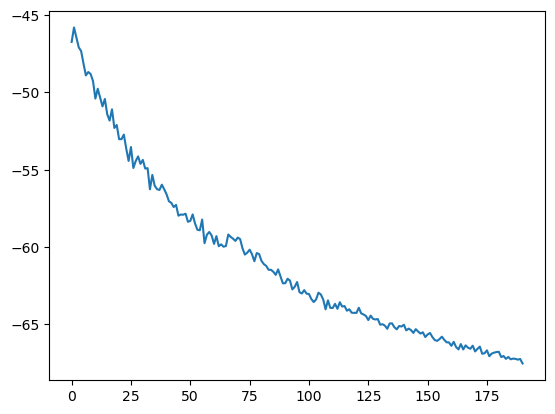

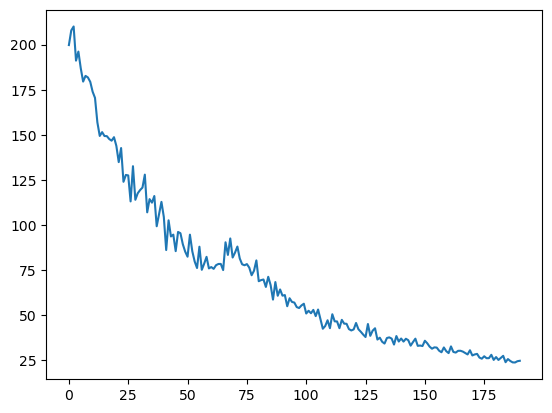

In [5]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        VarE_data.plot()
        plt.show()

In [6]:
# symmetrize the trained NQS

symm = ParticleConserve(18) + SpinInverse() + D6()
symm_state = symm(state)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000, n_neighbor=[1, 2])
tdvp = qtx.optimizer.TDVP(symm_state, H)

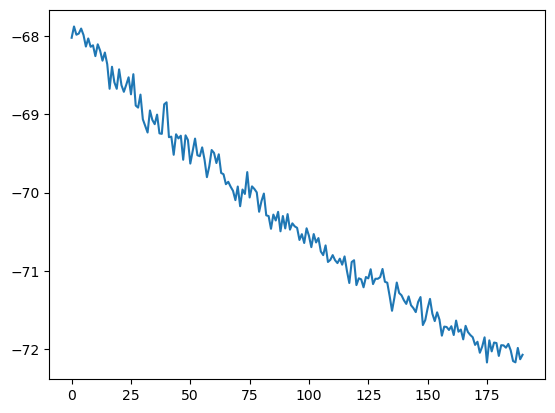

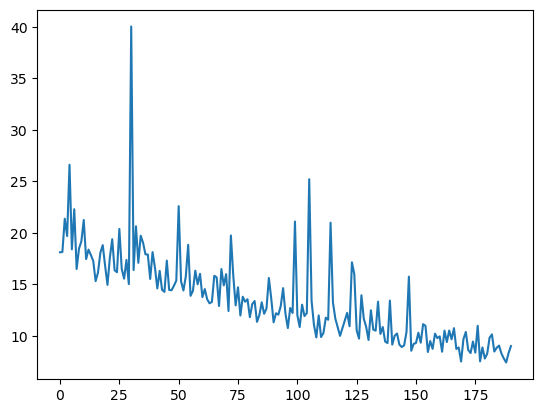

In [7]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        VarE_data.plot()
        plt.show()